In [6]:
!pip install -U swifter


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 633 kB 6.4 kB/s  eta 0:00:01
     |████████████████████████████████| 579 kB 6.2 kB/s  eta 0:00:01
     |████████████████████████████████| 48.2 MB 6.9 kB/s  eta 0:00:01
     |████████████████████████████████| 17.3 MB 1.1 kB/s  eta 0:00:01


     |████████████████████████████████| 1.5 MB 8.3 kB/s s eta 0:00:01
     |████████████████████████████████| 72 kB 48 kB/s /s eta 0:00:01
     |████████████████████████████████| 78 kB 511 kB/s s eta 0:00:01
     |████████████████████████████████| 3.1 MB 115.7 MB/s eta 0:00:01
     |████████████████████████████████| 201 kB 125.5 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 132.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 2.6 MB/s s eta 0:00:01
     |████████████████████████████████| 159 kB 129.9 MB/s eta 0:00:01
     |████████████████████████████████| 324 kB 126.4 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 330 kB/s s eta 0:00:01
     |████████████████████████████████| 85 kB 3.1 MB/s s eta 0:00:01


     |████████████████████████████████| 198 kB 130.4 MB/s eta 0:00:01
  Created wheel for swifter: filename=swifter-1.0.7-py3-none-any.whl size=13976 sha256=fa3939a9fd433671d25cec70142e3e7995250cc6f6a7b255d4b53f796c07bed2
  Stored in directory: /scratch/pw1329/.cache/pip/wheels/cc/a3/ca/87533bb1e618d962a03e9286da38e9e21b1d135848f1112bda
  Created wheel for gpustat: filename=gpustat-0.6.0-py3-none-any.whl size=12617 sha256=b8fdd7cf2bb688fb6b4442493c0ada30c2634eab8c0f5f4b84422411cbafa5ba
  Stored in directory: /scratch/pw1329/.cache/pip/wheels/0d/d9/80/b6cbcdc9946c7b50ce35441cc9e7d8c5a9d066469ba99bae44
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19191 sha256=03f69e98b67e61648b052ce9b900e1104340c66432c039db0da3c7823e7fa6ad
  Stored in directory: /scratch/pw1329/.cache/pip/wheels/b9/b1/68/cb4feab29709d4155310d29a421389665dcab9eb3b679b527b
Successfully built swifter gpustat nvidia-ml-py3
ERROR: modin 0.9.1 has requirement pandas==1.2.3, but you'll

In [10]:
!pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/pw1329/.local/lib/python3.8/site-packages (1.2.4)


In [11]:
import re
import pandas as pd
import analysis_relabel_funcs
from analysis import read_dfs
import torch
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from torch.nn import Softmax
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import pickle
import swifter
import time
%matplotlib inline

In [12]:
MODEL_RELABEL = {
    'BERT-Jigsaw': ["not toxic", "toxic"], 
    'BERT-SBIC-offensive': ["Not", "Maybe", "Offensive"],
    'BERT-SBIC-targetcategory': ['none', 'body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim'], # not used
    'BERT-eec-emotion': ['none', 'anger','fear', 'joy', 'sadness'], # not used
    'BERT-jigsaw-identityhate': ['Not', "Yes"],
    'BERT-jigsaw-severetoxic': ["Not", "Yes"],
    'BERT-mdgender-convai-binary': ["female", "male"],
    'BERT-mdgender-convai-ternary': ["female", "male", "neutral"],
    'BERT-mdgender-wizard': ["neutral", "female", "male"],
    'BERT-rtgender-opgender-annotations': ["man", "woman"] 
}

In [13]:
def _softmax_and_relabel(predictions, categorical_labels):
    # takes in a torch.Tensor of predictions and a list of categorical labels, returns a tuple of (softmax tensor, categorical label)
    m = Softmax(dim=0)
    sm = m(predictions)
    return sm, categorical_labels[sm.argmax().item()]

def score(labels, predictions):
    softmax_preds, category = _softmax_and_relabel(predictions, labels)
    # scores are always the difference between the first and last
    return softmax_preds[-1] - softmax_preds[0], category

In [14]:
TOXIC_MODELS = {"Cameron/BERT-Jigsaw", 'Cameron/BERT-SBIC-offensive', 'Cameron/BERT-jigsaw-identityhate', 'Cameron/BERT-jigsaw-severetoxic'}
GENDER_MODELS = {'Cameron/BERT-mdgender-convai-binary', 'Cameron/BERT-mdgender-convai-ternary', 'Cameron/BERT-mdgender-wizard', 'Cameron/BERT-rtgender-opgender-annotations'}

In [15]:
FILES="""
Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out
Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out
Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out
Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out
Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out
Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out
Cameron-BERT-Jigsaw-00:41:54-air_dialogue-train-eval.out
Cameron-BERT-Jigsaw-00:42:14-ted_talks_iwslt-train-eval.out
Cameron-BERT-Jigsaw-01:08:42-tweet_eval-train-eval.out
Cameron-BERT-Jigsaw-01:15:29-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:40:35-conv_ai_3-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:41:55-air_dialogue-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:42:20-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:43:43-tweet_eval-train-eval.out
Cameron-BERT-jigsaw-identityhate-00:53:13-empathetic_dialogues-train-eval.out
Cameron-BERT-jigsaw-identityhate-01:32:40-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-severetoxic-00:40:37-conv_ai_3-train-eval.out
Cameron-BERT-jigsaw-severetoxic-00:42:01-air_dialogue-train-eval.out
Cameron-BERT-jigsaw-severetoxic-00:42:21-ted_talks_iwslt-train-eval.out
Cameron-BERT-jigsaw-severetoxic-01:16:40-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:40:37-conv_ai_3-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:42:04-air_dialogue-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:42:19-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:43:41-tweet_eval-train-eval.out
Cameron-BERT-mdgender-convai-binary-00:53:18-empathetic_dialogues-train-eval.out
Cameron-BERT-mdgender-convai-binary-01:30:30-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out
Cameron-BERT-mdgender-convai-ternary-00:42:00-air_dialogue-train-eval.out
Cameron-BERT-mdgender-convai-ternary-00:42:18-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-convai-ternary-01:16:10-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-wizard-00:40:34-conv_ai_3-train-eval.out
Cameron-BERT-mdgender-wizard-00:41:58-air_dialogue-train-eval.out
Cameron-BERT-mdgender-wizard-00:42:15-ted_talks_iwslt-train-eval.out
Cameron-BERT-mdgender-wizard-00:43:40-tweet_eval-train-eval.out
Cameron-BERT-mdgender-wizard-00:53:08-empathetic_dialogues-train-eval.out
Cameron-BERT-mdgender-wizard-01:14:09-ted_talks_iwslt-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:30:31-conv_ai_3-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:40:32-conv_ai_3-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:42:00-air_dialogue-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-00:42:14-ted_talks_iwslt-train-eval.out
Cameron-BERT-rtgender-opgender-annotations-01:17:11-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out
Cameron-BERT-SBIC-offensive-00:41:58-air_dialogue-train-eval.out
Cameron-BERT-SBIC-offensive-00:42:20-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-offensive-00:53:12-empathetic_dialogues-train-eval.out
Cameron-BERT-SBIC-offensive-01:08:26-tweet_eval-train-eval.out
Cameron-BERT-SBIC-offensive-01:31:48-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-targetcategory-00:40:41-conv_ai_3-train-eval.out
Cameron-BERT-SBIC-targetcategory-00:42:00-air_dialogue-train-eval.out
Cameron-BERT-SBIC-targetcategory-00:42:18-ted_talks_iwslt-train-eval.out
Cameron-BERT-SBIC-targetcategory-01:06:42-tweet_eval-train-eval.out
Cameron-BERT-SBIC-targetcategory-01:17:08-ted_talks_iwslt-train-eval.out
"""

In [16]:
eval_files = {}
toxic_files = []
gender_files = []

def create_tup(filename, model_name):
    return (model_name.replace("Cameron/", ""), "results/" + filename)

for filename in FILES.strip().split("\n"):
    s = filename.split(":")
    model_name = s[0][:-3]
    model_name = model_name.replace("Cameron-", "Cameron/")
    eval_dataset_name = s[-1][3:-15]
    model_type = None
    if eval_dataset_name not in eval_files:
        eval_files[eval_dataset_name] = {"toxic": [], "gender": []}
    if model_name in TOXIC_MODELS:
        model_type = "TOXIC"
        eval_files[eval_dataset_name]["toxic"].append(create_tup(filename, model_name))
        toxic_files.append(filename)
    elif model_name in GENDER_MODELS:
        model_type = "GENDER"
        eval_files[eval_dataset_name]["gender"].append(create_tup(filename, model_name))
        gender_files.append(filename)
    else:
        print(f"Model type is not classified, please classify {model_name} with file {filename}")
        continue
    print(f"Model name: {model_name} | eval dataset: {eval_dataset_name}" )

Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-00:40:36-conv_ai_3-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-00:41:55-air_dialogue-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-00:42:19-ted_talks_iwslt-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-01:06:29-tweet_eval-train-eval.out
Model type is not classified, please classify Cameron/BERT-eec-emotion with file Cameron-BERT-eec-emotion-01:24:02-ted_talks_iwslt-train-eval.out
Model name: Cameron/BERT-Jigsaw | eval dataset: conv_ai_3
Model name: Cameron/BERT-Jigsaw | eval dataset: air_dialogue
Model name: Cameron/BERT-Jigsaw | eval dataset: ted_talks_iwslt
Model name: Cameron/BERT-Jigsaw | eval dataset: tweet_eval
Model name: Cameron/BERT-Jigsaw | eval dat

In [17]:
print(f"Found {len(toxic_files)} toxic results and {len(gender_files)} gender files")

Found 21 toxic results and 21 gender files


In [18]:
eval_files

{'conv_ai_3': {'toxic': [('BERT-Jigsaw',
    'results/Cameron-BERT-Jigsaw-00:40:33-conv_ai_3-train-eval.out'),
   ('BERT-jigsaw-identityhate',
    'results/Cameron-BERT-jigsaw-identityhate-00:40:35-conv_ai_3-train-eval.out'),
   ('BERT-jigsaw-severetoxic',
    'results/Cameron-BERT-jigsaw-severetoxic-00:40:37-conv_ai_3-train-eval.out'),
   ('BERT-SBIC-offensive',
    'results/Cameron-BERT-SBIC-offensive-00:40:33-conv_ai_3-train-eval.out')],
  'gender': [('BERT-mdgender-convai-binary',
    'results/Cameron-BERT-mdgender-convai-binary-00:40:37-conv_ai_3-train-eval.out'),
   ('BERT-mdgender-convai-ternary',
    'results/Cameron-BERT-mdgender-convai-ternary-00:40:41-conv_ai_3-train-eval.out'),
   ('BERT-mdgender-wizard',
    'results/Cameron-BERT-mdgender-wizard-00:40:34-conv_ai_3-train-eval.out'),
   ('BERT-rtgender-opgender-annotations',
    'results/Cameron-BERT-rtgender-opgender-annotations-00:30:31-conv_ai_3-train-eval.out'),
   ('BERT-rtgender-opgender-annotations',
    'results/Came

In [22]:
def cross_tab_gender_toxic(eval_file_split, eval_dataset_name, return_one = False):
    eval_crosstabs = []
    count = 0.0
    tot = len(eval_file_split["toxic"]) * len(eval_file_split["gender"])
    for toxic_tup in eval_file_split["toxic"]:
        toxic_model_name = toxic_tup[0]
        toxic_filename = toxic_tup[1]
        for gender_tup in eval_file_split["gender"]:
            gender_model_name = gender_tup[0]
            gender_filename = gender_tup[1]
            
            # for using sbc and rt_gender for conv_ai
            _, _, combined = read_dfs(toxic_filename, 
                                      gender_filename,
                                     suffixes=("_" + toxic_model_name, "_" + gender_model_name))
            pred_toxic = "predictions_" + toxic_model_name
            pred_gender = "predictions_" + gender_model_name
            
            print("relabeling toxic")
            p = partial(score, MODEL_RELABEL[toxic_model_name])
            s = combined[pred_toxic].swifter.apply(p)
            scores_col = f"scores_{toxic_model_name}"
            category_col = f"category_{toxic_model_name}"
            
            s = pd.DataFrame(s.tolist(), columns=[scores_col, category_col])
            s[scores_col] = s[scores_col].swifter.apply(lambda x: x.item()) # comes back as a tensor, change it to float
            combined = combined.join(s)
            
            print("relabeling gender")
            p = partial(score, MODEL_RELABEL[gender_model_name])
            s = combined[pred_gender].swifter.apply(p)
            scores_col = f"scores_{gender_model_name}"
            category_col = f"category_{gender_model_name}"
            
            s = pd.DataFrame(s.tolist(), columns=[scores_col, category_col])
            s[scores_col] = s[scores_col].swifter.apply(lambda x: x.item()) # comes back as a tensor, change it to float
            combined = combined.join(s)
            
            
            eval_crosstabs.append({
                "toxic_model_name": toxic_model_name,
                "gender_model_name": gender_model_name,
                "toxic_attr": (f"scores_{toxic_model_name}", f"category_{toxic_model_name}"),
                "gender_attr": (f"scores_{gender_model_name}", f"category_{gender_model_name}"),
                "df": combined
            })
            count += 1.0
            print(f"Crossing {toxic_model_name} x {gender_model_name} for {eval_dataset_name}, finished {count/tot*100}%")
            if return_one:
                return eval_crosstabs
    return eval_crosstabs

In [34]:
crosstabs = []
for eval_dataset_name, eval_f in eval_files.items():
    if eval_dataset_name == "air_dialogue" or eval_dataset_name == "empathetic_dialogues":
        print(f'ignoring {eval_dataset_name} for now')
        continue
    print(f"Analyzing {eval_dataset_name}")
    try:
        ct = cross_tab_gender_toxic(eval_f, eval_dataset_name, return_one=False)
        crosstabs.append((eval_dataset_name, ct))
    except Exception as e:
        print(e)
        raise 
    

Analyzing conv_ai_3
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for conv_ai_3, finished 5.0%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for conv_ai_3, finished 10.0%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-wizard for conv_ai_3, finished 15.0%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for conv_ai_3, finished 20.0%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for conv_ai_3, finished 25.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-binary for conv_ai_3, finished 30.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-ternary for conv_ai_3, finished 35.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-wizard for conv_ai_3, finished 40.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-rtgender-opgender-annotations for conv_ai_3, finished 45.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-rtgender-opgender-annotations for conv_ai_3, finished 50.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-binary for conv_ai_3, finished 55.00000000000001%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-ternary for conv_ai_3, finished 60.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-wizard for conv_ai_3, finished 65.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-rtgender-opgender-annotations for conv_ai_3, finished 70.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-rtgender-opgender-annotations for conv_ai_3, finished 75.0%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-binary for conv_ai_3, finished 80.0%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for conv_ai_3, finished 85.0%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for conv_ai_3, finished 90.0%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for conv_ai_3, finished 95.0%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for conv_ai_3, finished 100.0%
ignoring air_dialogue for now
Analyzing ted_talks_iwslt
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 1.5625%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 3.125%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 4.6875%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 6.25%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 7.8125%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 9.375%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 10.9375%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 12.5%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 14.0625%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 15.625%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 17.1875%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 18.75%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 20.3125%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-wizard for ted_talks_iwslt, finished 21.875%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 23.4375%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 25.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 26.5625%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 28.125%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 29.6875%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 31.25%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-wizard for ted_talks_iwslt, finished 32.8125%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-wizard for ted_talks_iwslt, finished 34.375%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 35.9375%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 37.5%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 39.0625%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 40.625%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 42.1875%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 43.75%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-wizard for ted_talks_iwslt, finished 45.3125%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-wizard for ted_talks_iwslt, finished 46.875%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 48.4375%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 50.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 51.5625%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 53.125%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 54.6875%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 56.25%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-wizard for ted_talks_iwslt, finished 57.8125%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-wizard for ted_talks_iwslt, finished 59.375%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 60.9375%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 62.5%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 64.0625%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 65.625%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 67.1875%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 68.75%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-wizard for ted_talks_iwslt, finished 70.3125%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-mdgender-wizard for ted_talks_iwslt, finished 71.875%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 73.4375%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-severetoxic x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 75.0%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 76.5625%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 78.125%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 79.6875%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 81.25%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for ted_talks_iwslt, finished 82.8125%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for ted_talks_iwslt, finished 84.375%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 85.9375%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 87.5%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 89.0625%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-binary for ted_talks_iwslt, finished 90.625%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 92.1875%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-ternary for ted_talks_iwslt, finished 93.75%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for ted_talks_iwslt, finished 95.3125%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for ted_talks_iwslt, finished 96.875%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 98.4375%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-rtgender-opgender-annotations for ted_talks_iwslt, finished 100.0%
Analyzing tweet_eval
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-convai-binary for tweet_eval, finished 16.666666666666664%
relabeling toxic



relabeling gender



Crossing BERT-Jigsaw x BERT-mdgender-wizard for tweet_eval, finished 33.33333333333333%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-convai-binary for tweet_eval, finished 50.0%
relabeling toxic



relabeling gender



Crossing BERT-jigsaw-identityhate x BERT-mdgender-wizard for tweet_eval, finished 66.66666666666666%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-convai-binary for tweet_eval, finished 83.33333333333334%
relabeling toxic



relabeling gender



Crossing BERT-SBIC-offensive x BERT-mdgender-wizard for tweet_eval, finished 100.0%
ignoring empathetic_dialogues for now


In [35]:
pickle.dump(crosstabs, open("crosstabs-pickle.p", "wb"))

In [36]:
crosstabs

[('conv_ai_3',
  [{'toxic_model_name': 'BERT-Jigsaw',
    'gender_model_name': 'BERT-mdgender-convai-binary',
    'toxic_attr': ('scores_BERT-Jigsaw', 'category_BERT-Jigsaw'),
    'gender_attr': ('scores_BERT-mdgender-convai-binary',
     'category_BERT-mdgender-convai-binary'),
    'df':                                                 sentence  \
    0                    yes am interested in obamas family    
    1             yes i want to know who made up his family    
    2                       yes this is what am looking for    
    3      no find the barack obamas family tree time mag...   
    4      no i need the specific time magazine article t...   
    ...                                                  ...   
    90798                 yes and the evolution there after    
    90799                                   that would help    
    90800                      no show me the history of it    
    90801  i would like to know how its evolved over the ...   
    90802 

In [37]:
def scale_and_generate(ct, dataset_name):
    toxic_model_name = ct["toxic_model_name"]
    gender_model_name = ct["gender_model_name"]
    toxic_score_col, toxic_category_col = ct["toxic_attr"]
    gender_score_col, gender_category_col = ct["gender_attr"]
    std_scaler = StandardScaler()
    df = ct["df"]
    # covariance 
    scores_df = df[[toxic_score_col, gender_score_col]]
    try:
        scores_df = pd.DataFrame(std_scaler.fit_transform(scores_df), columns=scores_df.columns)
    except Exception as e:
        print(df)
        print(f"FAILED TO GENERATE COVARIANCE FOR {dataset_name} WITH MODELS TOXIC: {toxic_model_name} GENDER: {gender_model_name}")
        return 
    cov = scores_df.cov()
    print(f"{dataset_name} | {toxic_category_col} | {gender_category_col}")
    print(cov)
    
    # contingency 
    contingency = pd.crosstab(df[toxic_category_col], df[gender_category_col])
    c, p, dof, expected = chi2_contingency(contingency)
    print(f"p-value is {p}")
    
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(contingency, annot=True, fmt="d", cmap="YlGnBu").set_title(dataset_name)
    
    print("------------------------------")

In [38]:
# for ct in crosstabs[0]:
#     scale_and_generate(ct, "conv_ai_3")

In [39]:
# uncomment and change below to load a pickle and use that for analysis!
# crosstabs = pickle.load(open("crosstabs-pickle.p"))


conv_ai_3 | category_BERT-Jigsaw | category_BERT-mdgender-convai-binary
                                    scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                            1.000011   
scores_BERT-mdgender-convai-binary            0.023196   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-Jigsaw                                            0.023196  
scores_BERT-mdgender-convai-binary                            1.000011  
p-value is 0.0645255368395195
------------------------------
conv_ai_3 | category_BERT-Jigsaw | category_BERT-mdgender-convai-ternary
                                     scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                             1.000011   
scores_BERT-mdgender-convai-ternary           -0.026192   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-Jigsaw                                             -0.026192  
scores_BERT-mdgender-convai-ternary                             1.000011

------------------------------
conv_ai_3 | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-binary
                                    scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                            1.000011   
scores_BERT-mdgender-convai-binary                    0.088857   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-SBIC-offensive                                    0.088857  
scores_BERT-mdgender-convai-binary                            1.000011  
p-value is 6.431694575348565e-130
------------------------------
conv_ai_3 | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-ternary
                                     scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                             1.000011   
scores_BERT-mdgender-convai-ternary                   -0.059193   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-SBIC-offensive                      

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdgender-convai-binary
                                    scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                            1.000042   
scores_BERT-mdgender-convai-binary           -0.030141   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-Jigsaw                                           -0.030141  
scores_BERT-mdgender-convai-binary                            1.000042  
p-value is 3.829783572981549e-05
------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdgender-convai-ternary
                                     scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                             1.000042   
scores_BERT-mdgender-convai-ternary            0.004465   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-Jigsaw                                              0.004465  
scores_BERT-mdgender-conva

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

p-value is 0.09299222762296809
------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdgender-convai-binary
                                    scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                            1.000042   
scores_BERT-mdgender-convai-binary           -0.030141   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-Jigsaw                                           -0.030141  
scores_BERT-mdgender-convai-binary                            1.000042  
p-value is 3.829783572981549e-05
------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdgender-convai-binary
                                    scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                            1.000042   
scores_BERT-mdgender-convai-binary           -0.030141   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-Jigsaw                                           -0.030141  
sco

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdgender-convai-ternary
                                     scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                             1.000042   
scores_BERT-mdgender-convai-ternary            0.004465   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-Jigsaw                                              0.004465  
scores_BERT-mdgender-convai-ternary                             1.000042  
p-value is 0.04032391124991877
------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdgender-wizard
                             scores_BERT-Jigsaw  scores_BERT-mdgender-wizard
scores_BERT-Jigsaw                     1.000042                    -0.037098
scores_BERT-mdgender-wizard           -0.037098                     1.000042
p-value is 1.6554792861598022e-11
------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-mdg

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                                   1.000042   
scores_BERT-rtgender-opgender-annotations            0.012763   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-Jigsaw                                                          0.012763  
scores_BERT-rtgender-opgender-annotations                                   1.000042  
p-value is 0.09299222762296809
------------------------------
ted_talks_iwslt | category_BERT-Jigsaw | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                                   1.000042   
scores_BERT-rtgender-opgender-annotations            0.012763   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-Jigsaw          

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-jigsaw-identityhate | category_BERT-mdgender-convai-ternary
                                     scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                                  0.0   
scores_BERT-mdgender-convai-ternary                              0.0   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-jigsaw-identityhate                                 0.000000  
scores_BERT-mdgender-convai-ternary                             1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-identityhate | category_BERT-mdgender-convai-ternary
                                     scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                                  0.0   
scores_BERT-mdgender-convai-ternary                              0.0   

                                     scores_BERT-mdgender-convai-ternary  
score

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

ted_talks_iwslt | category_BERT-jigsaw-identityhate | category_BERT-mdgender-wizard
                                 scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                              0.0   
scores_BERT-mdgender-wizard                                  0.0   

                                 scores_BERT-mdgender-wizard  
scores_BERT-jigsaw-identityhate                     0.000000  
scores_BERT-mdgender-wizard                         1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-identityhate | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                                        0.0   
scores_BERT-rtgender-opgender-annotations                              0.0   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-jigsaw-identityhate                         

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-jigsaw-identityhate | category_BERT-mdgender-convai-binary
                                    scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                                 0.0   
scores_BERT-mdgender-convai-binary                              0.0   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-jigsaw-identityhate                               0.000000  
scores_BERT-mdgender-convai-binary                            1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-identityhate | category_BERT-mdgender-convai-ternary
                                     scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                                  0.0   
scores_BERT-mdgender-convai-ternary                              0.0   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-jig

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-convai-binary
                                    scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                            1.000042   
scores_BERT-mdgender-convai-binary                       -0.138415   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-jigsaw-severetoxic                               -0.138415  
scores_BERT-mdgender-convai-binary                            1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-convai-binary
                                    scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                            1.000042   
scores_BERT-mdgender-convai-binary                       -0.138415   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-jigsaw-severetoxi

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-wizard
                                scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                        1.000042   
scores_BERT-mdgender-wizard                          -0.028275   

                                scores_BERT-mdgender-wizard  
scores_BERT-jigsaw-severetoxic                    -0.028275  
scores_BERT-mdgender-wizard                        1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-wizard
                                scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                        1.000042   
scores_BERT-mdgender-wizard                          -0.028275   

                                scores_BERT-mdgender-wizard  
scores_BERT-jigsaw-severetoxic                    -0.028275  
scores_BERT-mdgender-wizard       

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                                   1.000042   
scores_BERT-rtgender-opgender-annotations                        0.053703   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-jigsaw-severetoxic                                              0.053703  
scores_BERT-rtgender-opgender-annotations                                   1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-convai-binary
                                    scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                            1.000042   
scores_BERT-mdgender-convai-binary                       -0.138415   

                                

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-convai-ternary
                                     scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                             1.000042   
scores_BERT-mdgender-convai-ternary                        0.021792   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-jigsaw-severetoxic                                  0.021792  
scores_BERT-mdgender-convai-ternary                             1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-mdgender-wizard
                                scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                        1.000042   
scores_BERT-mdgender-wizard                          -0.028275   

                                scores_BERT-mdgender-wizard  
scores_BERT-jigsaw-severetoxic                   

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                                   1.000042   
scores_BERT-rtgender-opgender-annotations                        0.053703   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-jigsaw-severetoxic                                              0.053703  
scores_BERT-rtgender-opgender-annotations                                   1.000042  
p-value is 1.0
------------------------------
ted_talks_iwslt | category_BERT-jigsaw-severetoxic | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-jigsaw-severetoxic  \
scores_BERT-jigsaw-severetoxic                                   1.000042   
scores_BERT-rtgender-opgender-annotations                        0.053703   

                                   

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-ternary
                                     scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                             1.000042   
scores_BERT-mdgender-convai-ternary                   -0.103916   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-SBIC-offensive                                     -0.103916  
scores_BERT-mdgender-convai-ternary                             1.000042  
p-value is 2.199394166653599e-43
------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-ternary
                                     scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                             1.000042   
scores_BERT-mdgender-convai-ternary                   -0.103916   

                                     scores_BERT-mdgender-convai-ternary  
scores_BERT-SBIC-offensive 

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-mdgender-wizard
                             scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                     1.000042   
scores_BERT-mdgender-wizard                   -0.119670   

                             scores_BERT-mdgender-wizard  
scores_BERT-SBIC-offensive                     -0.119670  
scores_BERT-mdgender-wizard                     1.000042  
p-value is 1.0206830515305587e-57
------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                                   1.000042   
scores_BERT-rtgender-opgender-annotations                    0.071714   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-SBIC-offensive                                                  0.071714  
scores_BERT-rt

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

p-value is 2.199394166653599e-43
------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-mdgender-wizard
                             scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                     1.000042   
scores_BERT-mdgender-wizard                   -0.119670   

                             scores_BERT-mdgender-wizard  
scores_BERT-SBIC-offensive                     -0.119670  
scores_BERT-mdgender-wizard                     1.000042  
p-value is 1.0206830515305587e-57
------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-mdgender-wizard
                             scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                     1.000042   
scores_BERT-mdgender-wizard                   -0.119670   

                             scores_BERT-mdgender-wizard  
scores_BERT-SBIC-offensive                     -0.119670  
scores_BERT-mdgender-wizard                     1.000042  
p-v

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax

------------------------------
ted_talks_iwslt | category_BERT-SBIC-offensive | category_BERT-rtgender-opgender-annotations
                                           scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                                   1.000042   
scores_BERT-rtgender-opgender-annotations                    0.071714   

                                           scores_BERT-rtgender-opgender-annotations  
scores_BERT-SBIC-offensive                                                  0.071714  
scores_BERT-rtgender-opgender-annotations                                   1.000042  
p-value is 4.2252046937227577e-17
------------------------------
tweet_eval | category_BERT-Jigsaw | category_BERT-mdgender-convai-binary
                                    scores_BERT-Jigsaw  \
scores_BERT-Jigsaw                            1.000005   
scores_BERT-mdgender-convai-binary           -0.070893   

                                    scores_BERT-mdgender-convai-binary  
scores_BE

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))


tweet_eval | category_BERT-Jigsaw | category_BERT-mdgender-wizard
                             scores_BERT-Jigsaw  scores_BERT-mdgender-wizard
scores_BERT-Jigsaw                     1.000005                    -0.010405
scores_BERT-mdgender-wizard           -0.010405                     1.000005
p-value is 1.599740453497858e-212
------------------------------
tweet_eval | category_BERT-jigsaw-identityhate | category_BERT-mdgender-convai-binary
                                    scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                                 0.0   
scores_BERT-mdgender-convai-binary                              0.0   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-jigsaw-identityhate                               0.000000  
scores_BERT-mdgender-convai-binary                            1.000005  
p-value is 1.0
------------------------------


<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))


tweet_eval | category_BERT-jigsaw-identityhate | category_BERT-mdgender-wizard
                                 scores_BERT-jigsaw-identityhate  \
scores_BERT-jigsaw-identityhate                              0.0   
scores_BERT-mdgender-wizard                                  0.0   

                                 scores_BERT-mdgender-wizard  
scores_BERT-jigsaw-identityhate                     0.000000  
scores_BERT-mdgender-wizard                         1.000005  
p-value is 1.0
------------------------------
tweet_eval | category_BERT-SBIC-offensive | category_BERT-mdgender-convai-binary
                                    scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                            1.000005   
scores_BERT-mdgender-convai-binary                   -0.088421   

                                    scores_BERT-mdgender-convai-binary  
scores_BERT-SBIC-offensive                                   -0.088421  
scores_BERT-mdgender-convai-binary                     

<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))
<ipython-input-37-dbde36c66708>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(9, 6))


tweet_eval | category_BERT-SBIC-offensive | category_BERT-mdgender-wizard
                             scores_BERT-SBIC-offensive  \
scores_BERT-SBIC-offensive                     1.000005   
scores_BERT-mdgender-wizard                   -0.036446   

                             scores_BERT-mdgender-wizard  
scores_BERT-SBIC-offensive                     -0.036446  
scores_BERT-mdgender-wizard                     1.000005  
p-value is 2.4723368074549645e-296
------------------------------


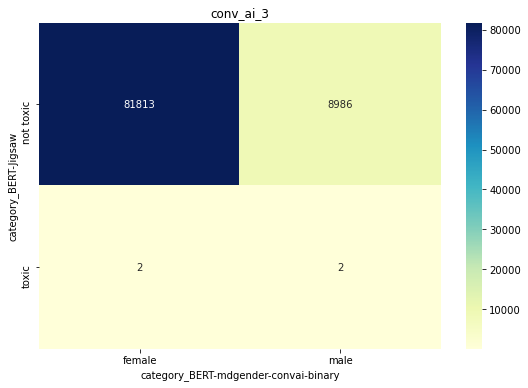

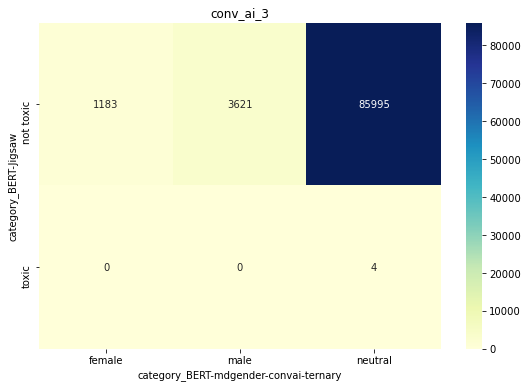

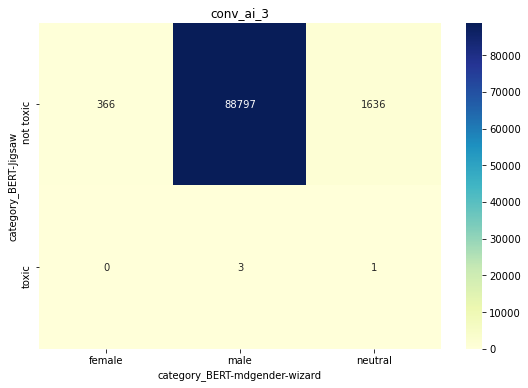

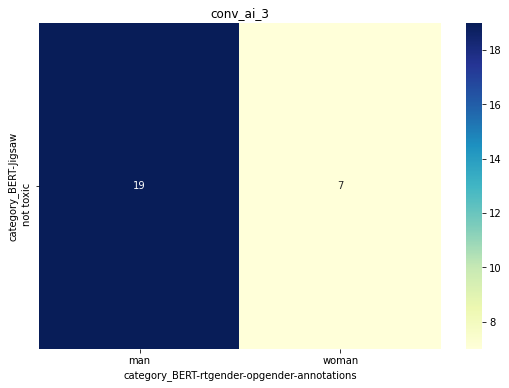

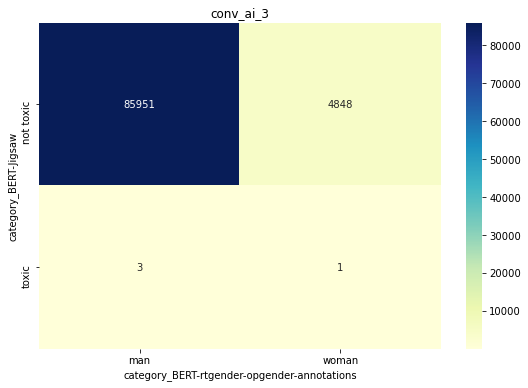

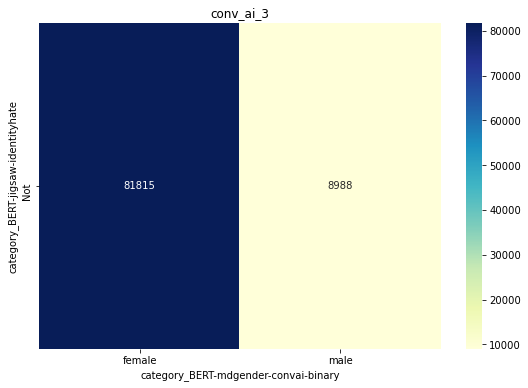

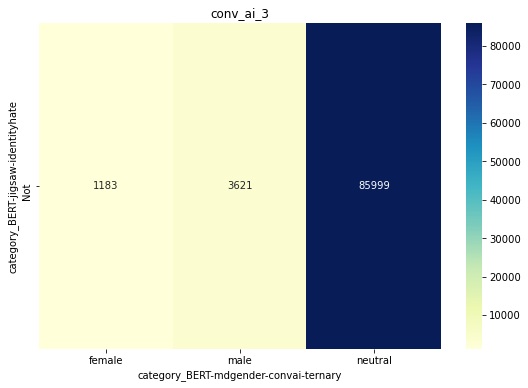

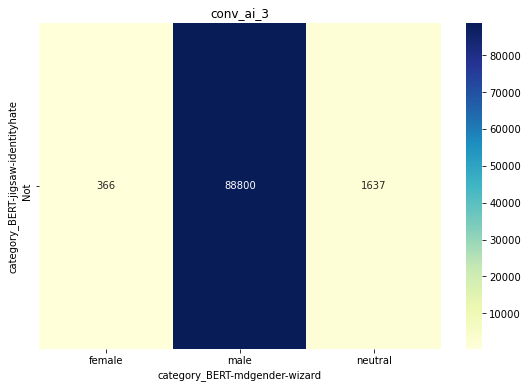

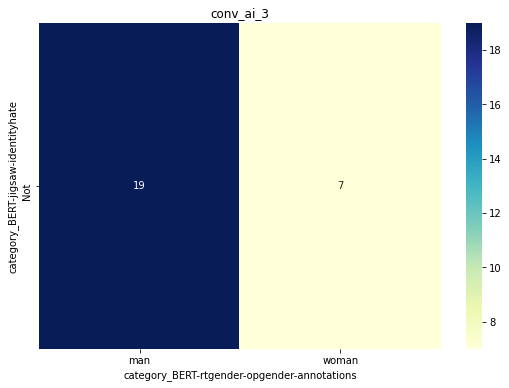

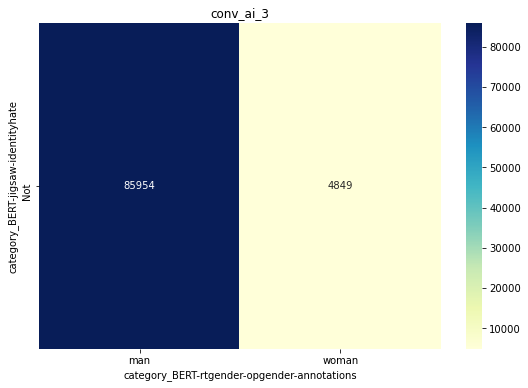

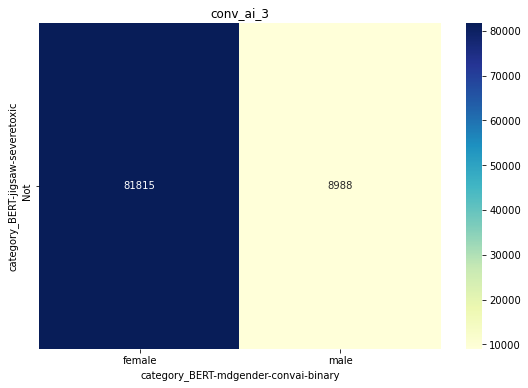

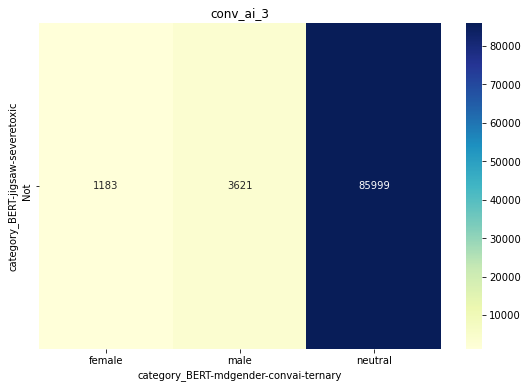

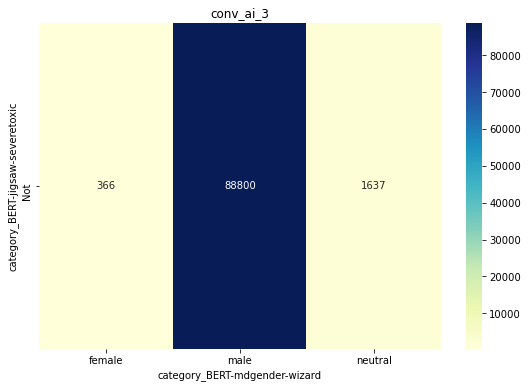

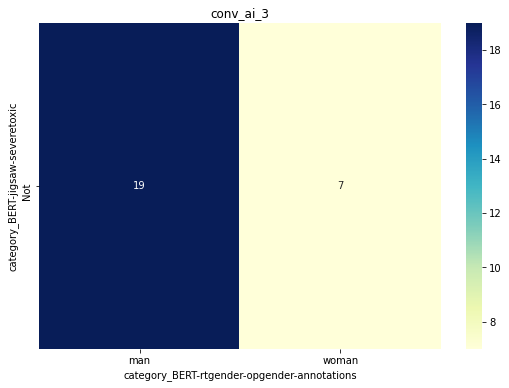

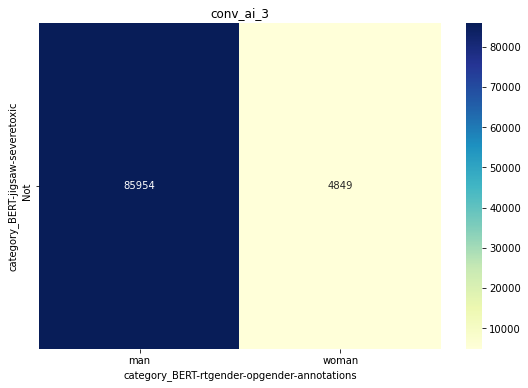

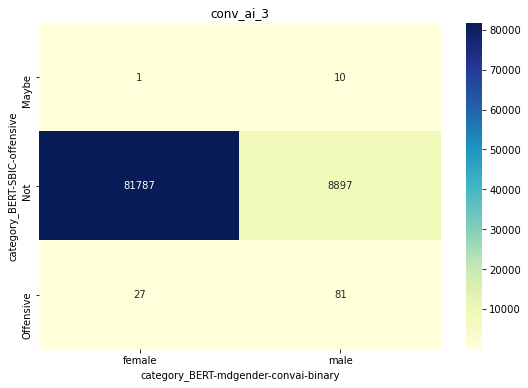

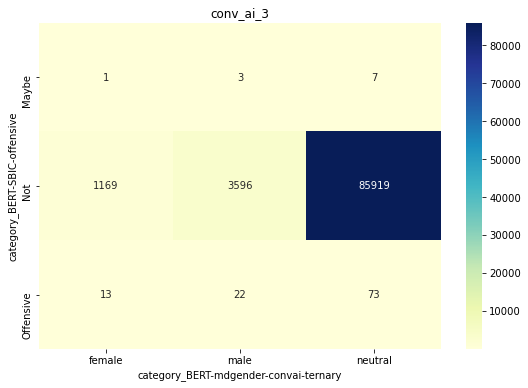

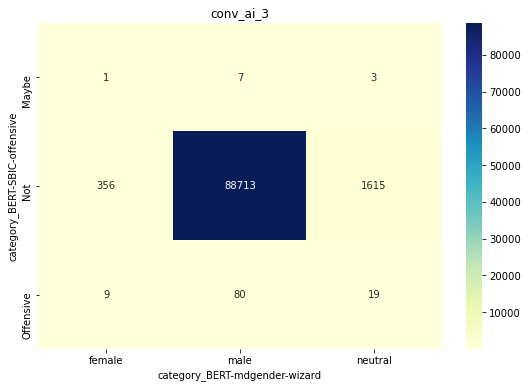

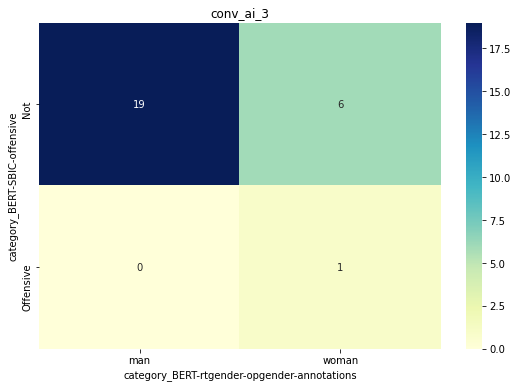

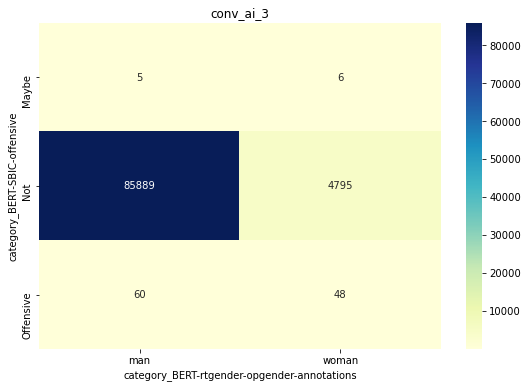

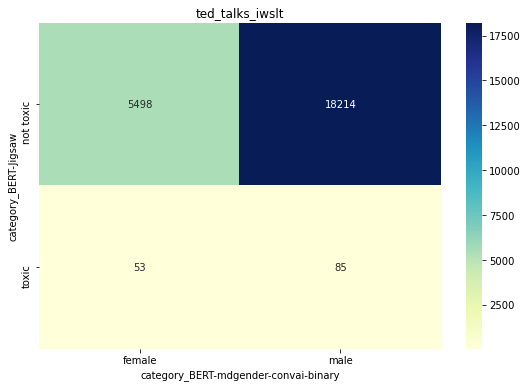

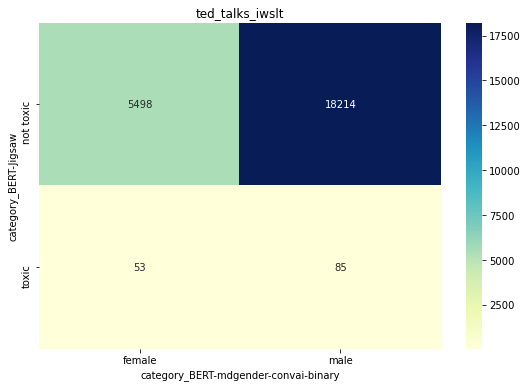

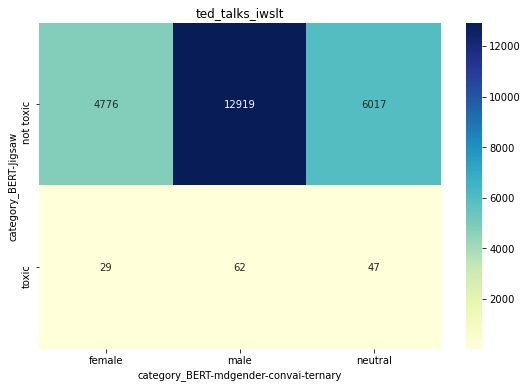

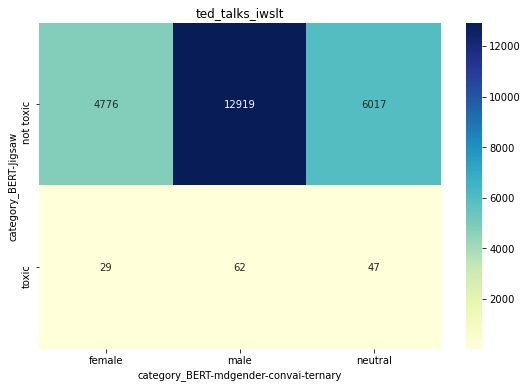

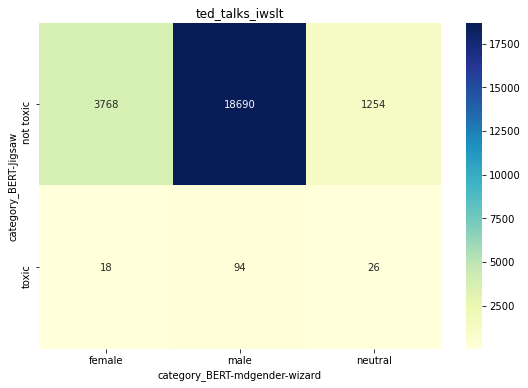

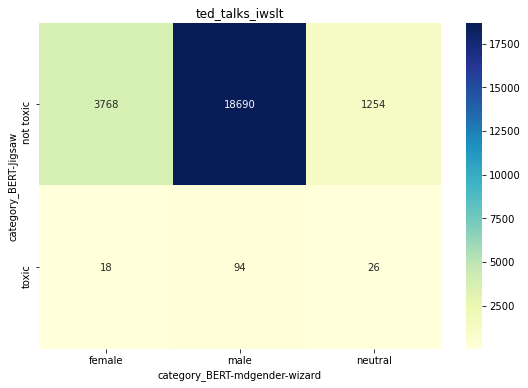

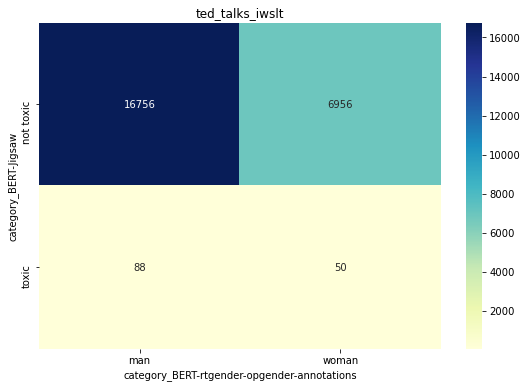

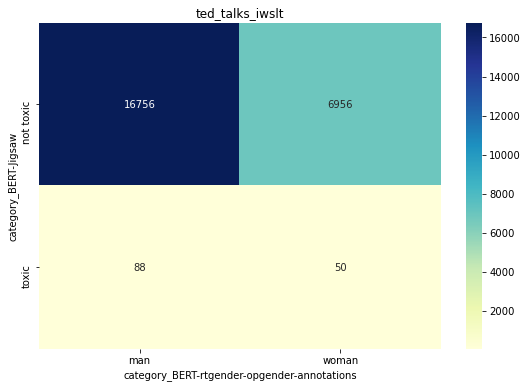

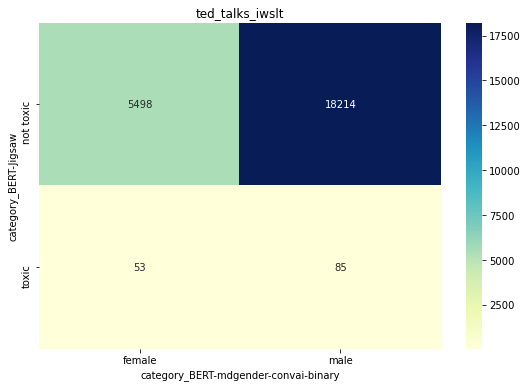

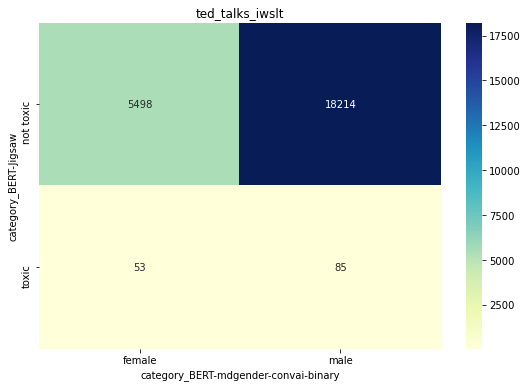

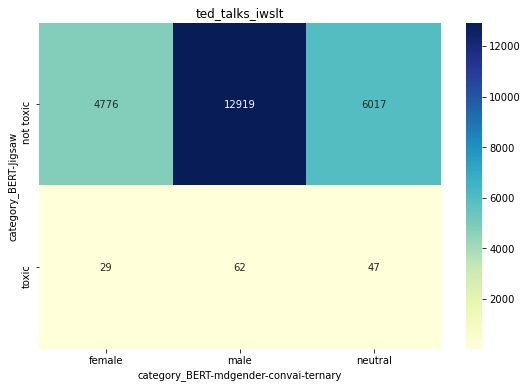

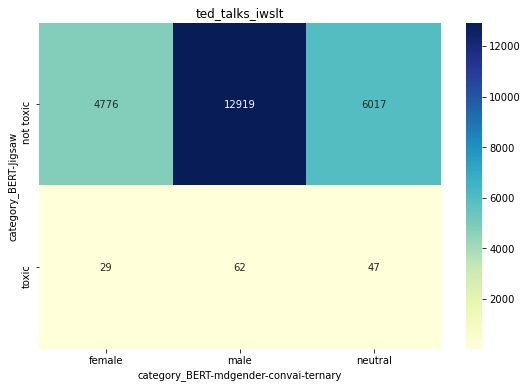

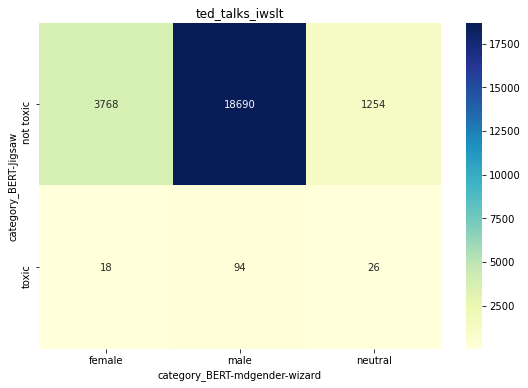

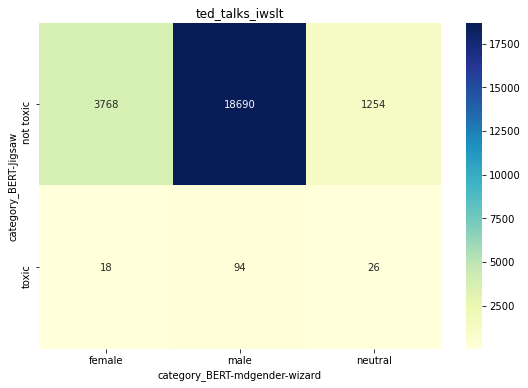

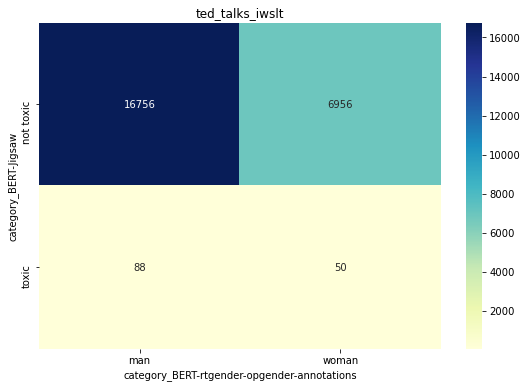

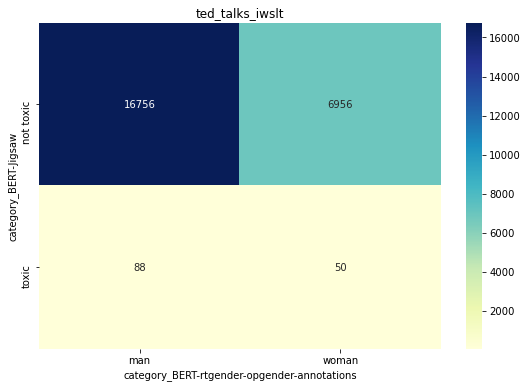

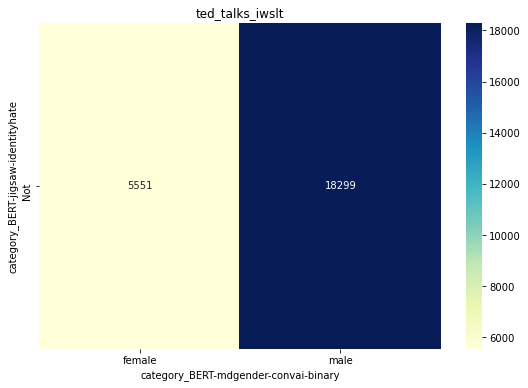

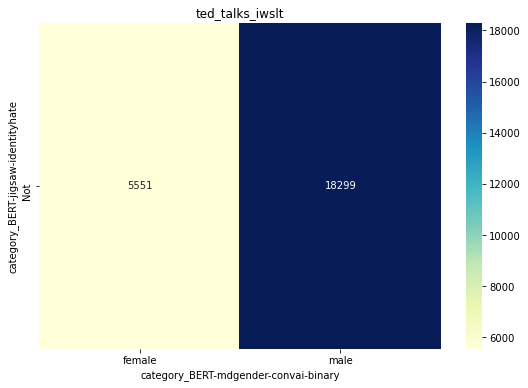

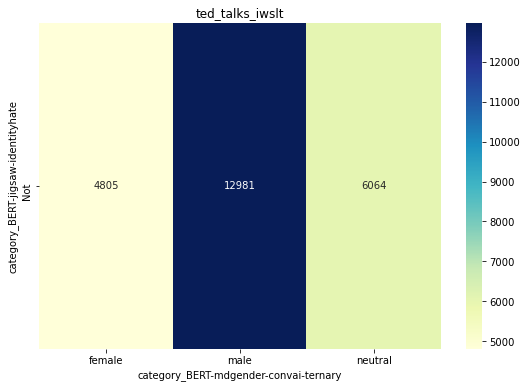

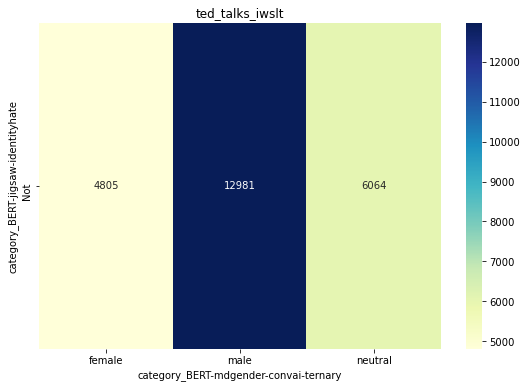

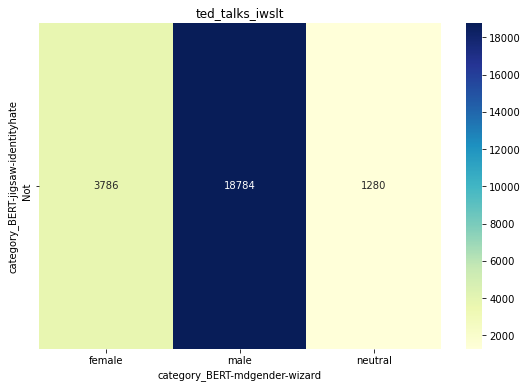

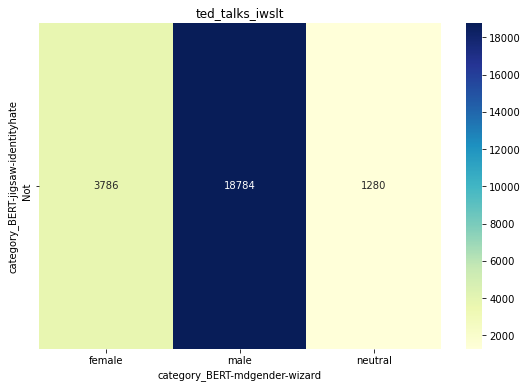

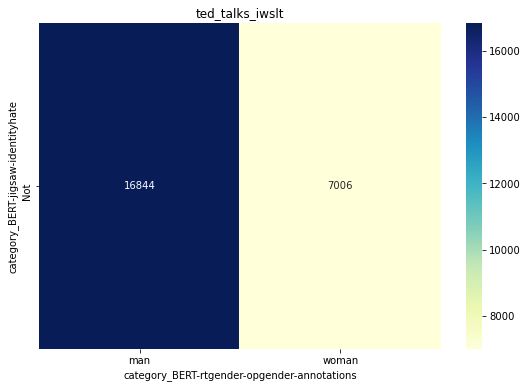

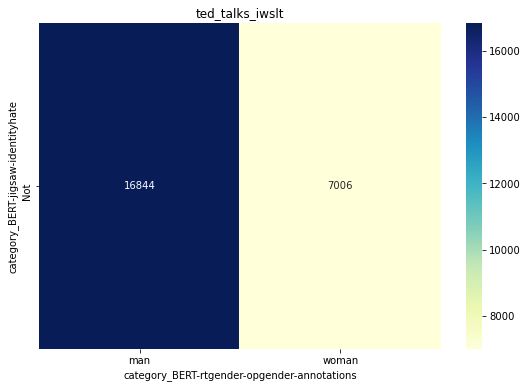

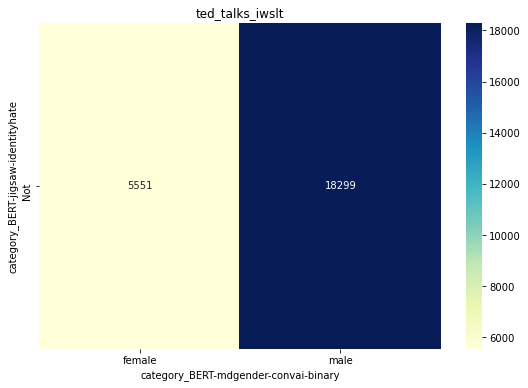

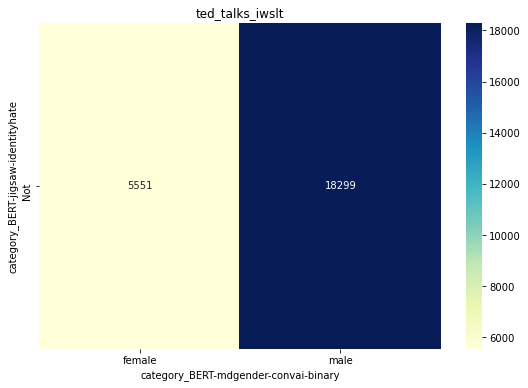

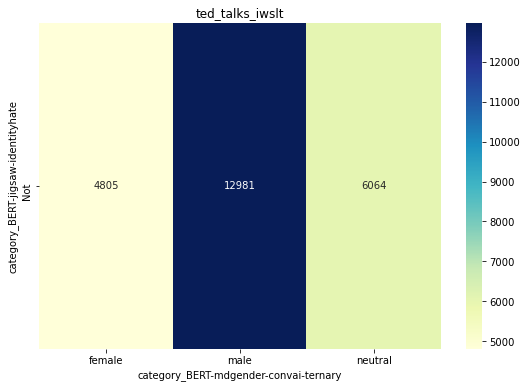

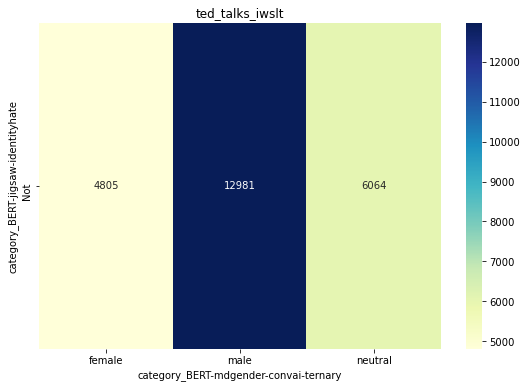

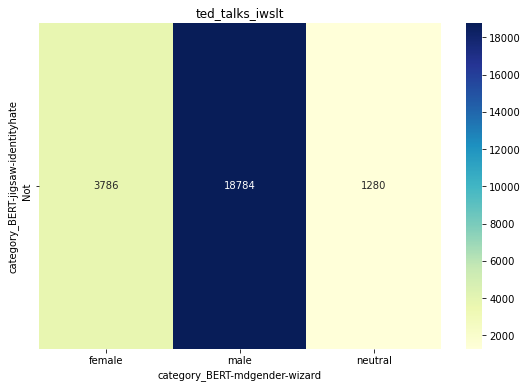

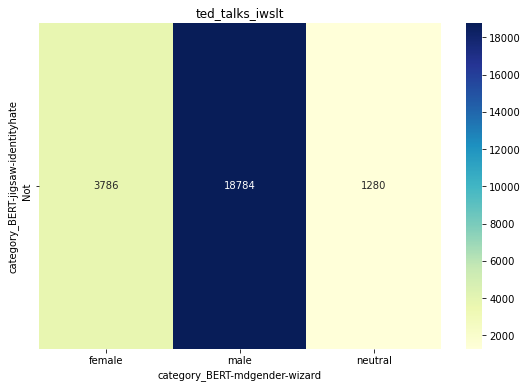

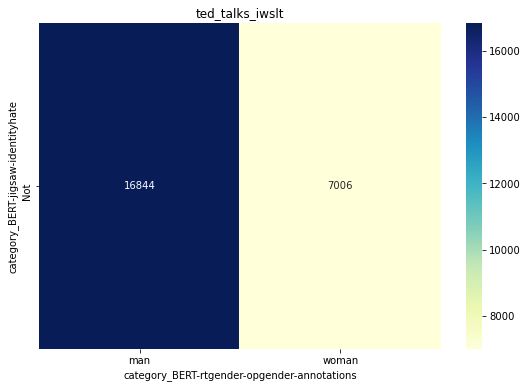

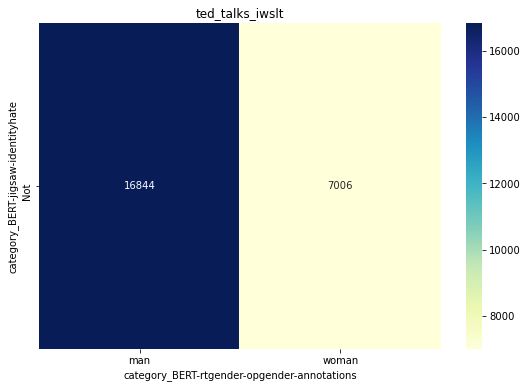

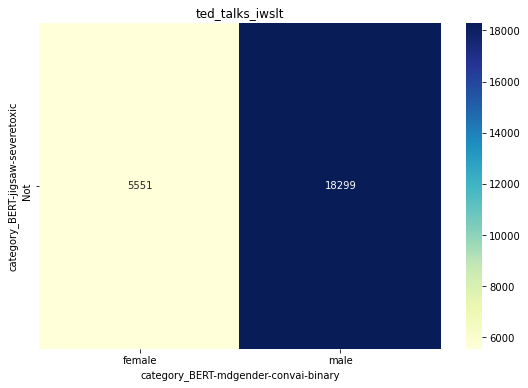

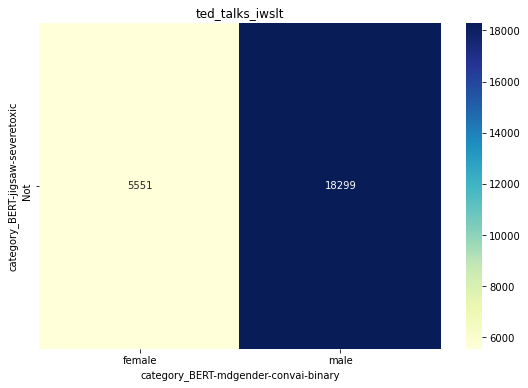

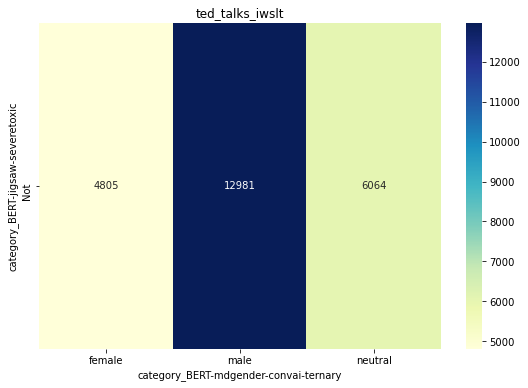

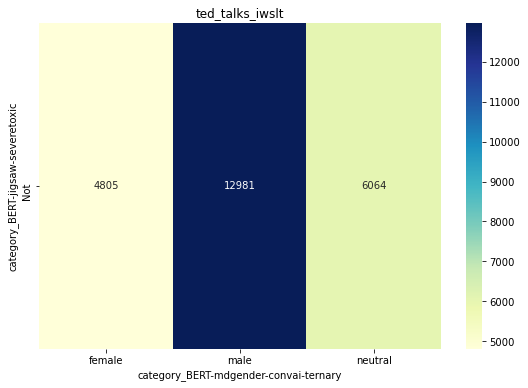

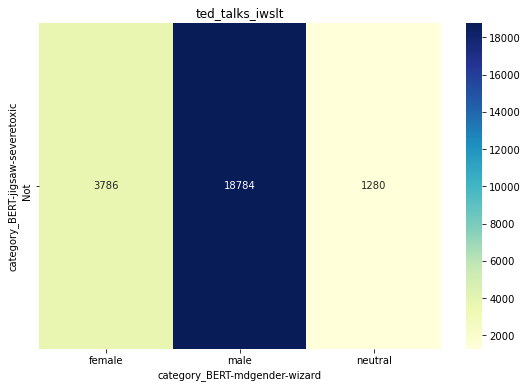

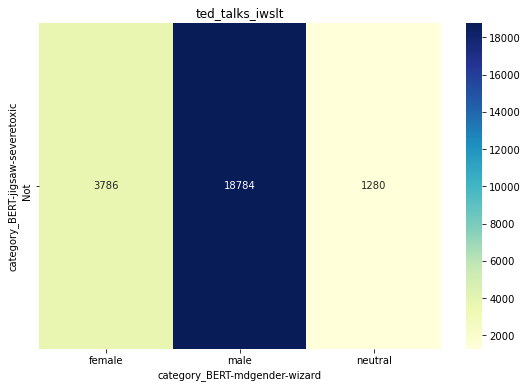

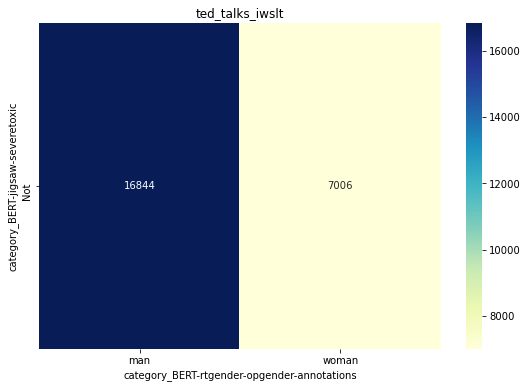

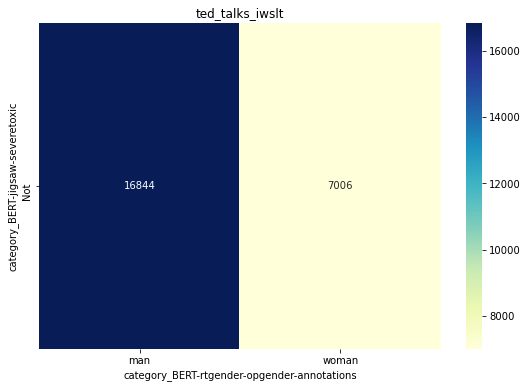

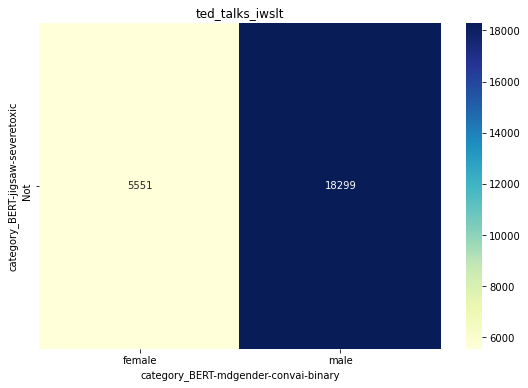

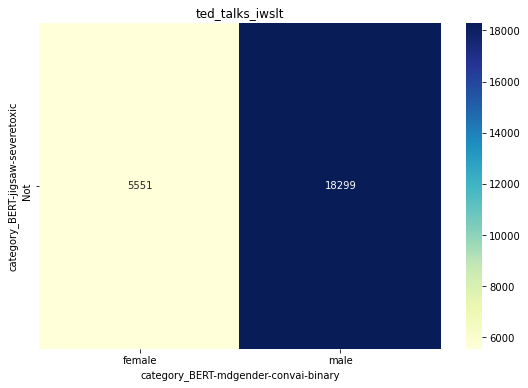

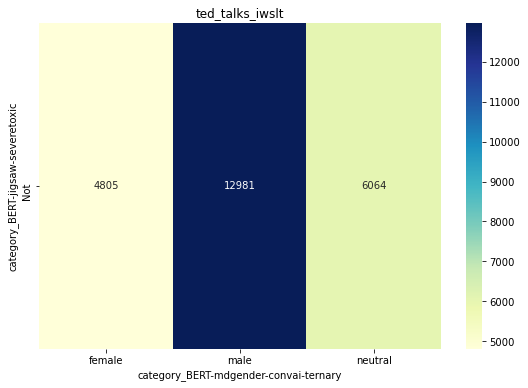

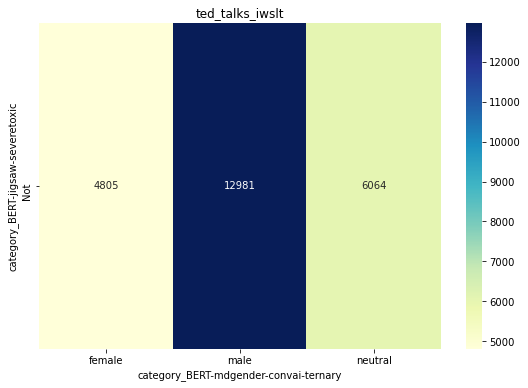

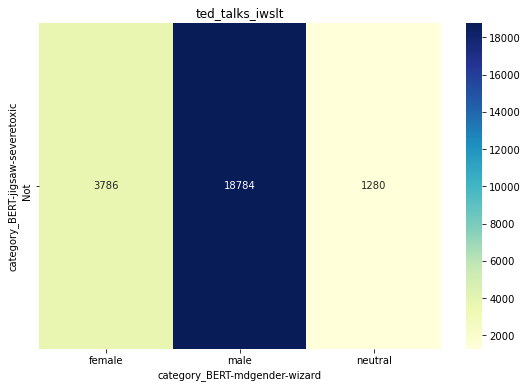

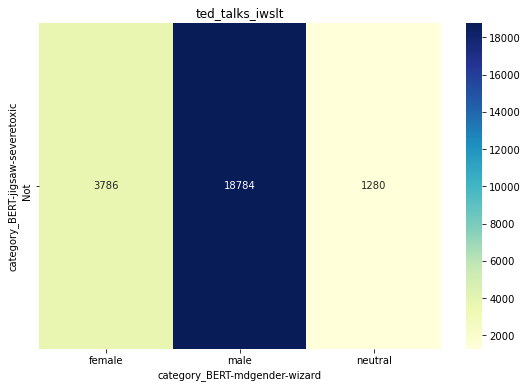

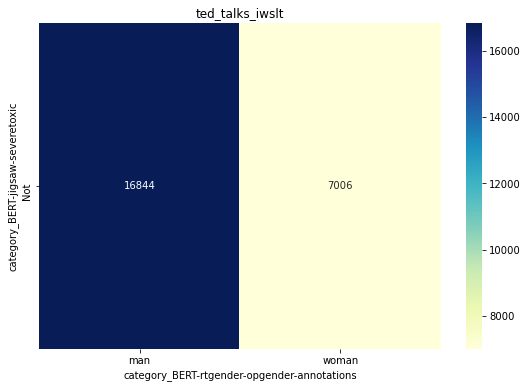

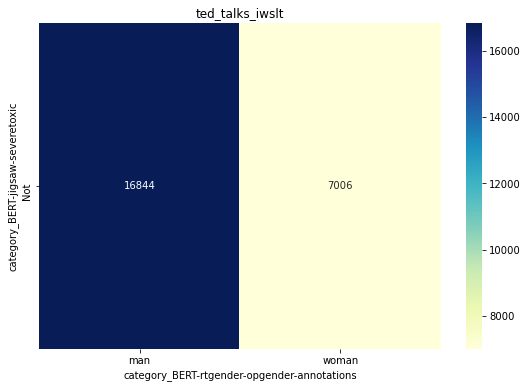

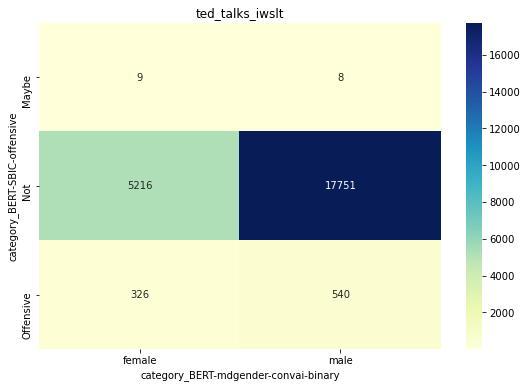

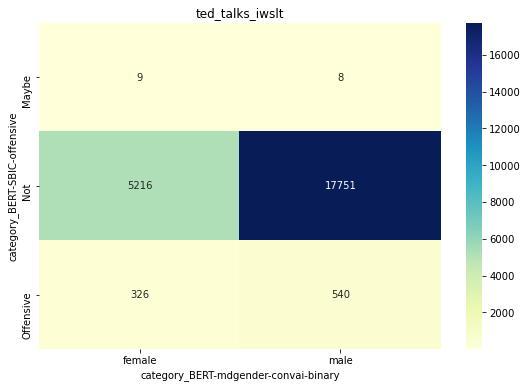

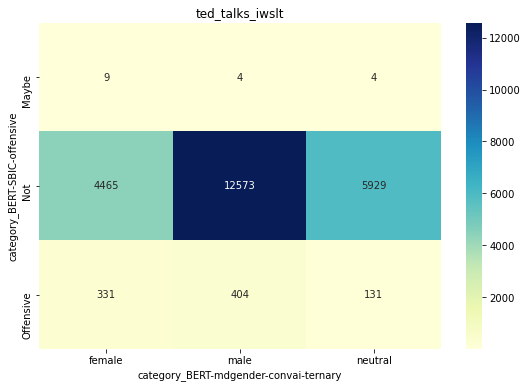

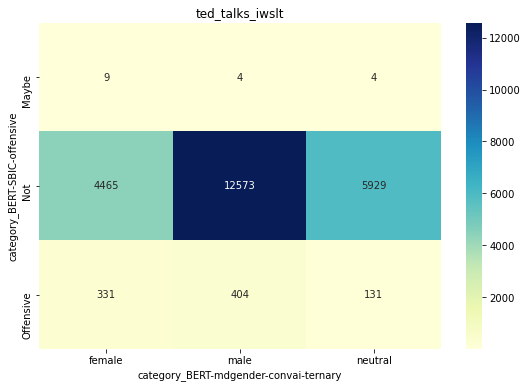

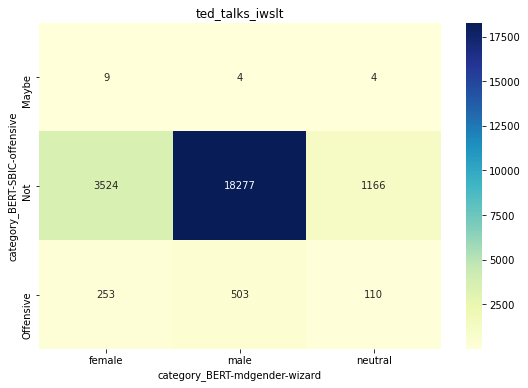

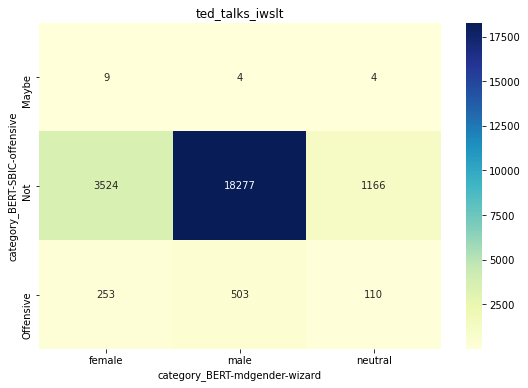

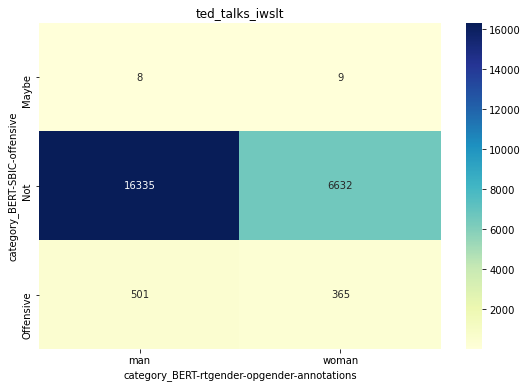

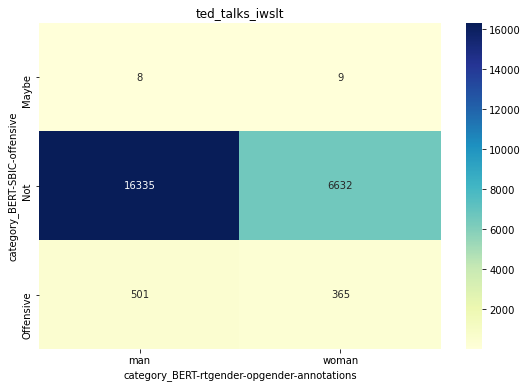

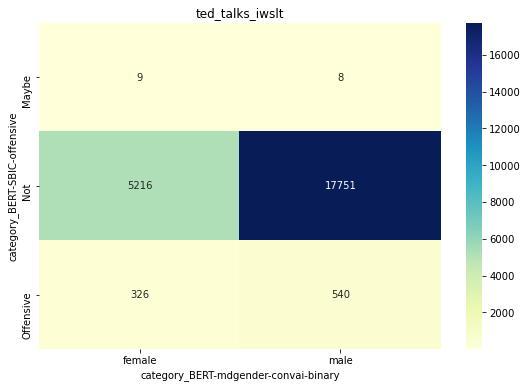

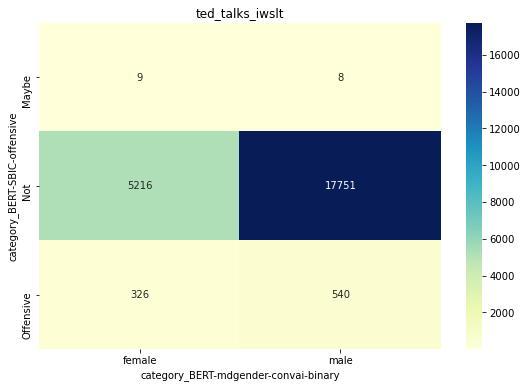

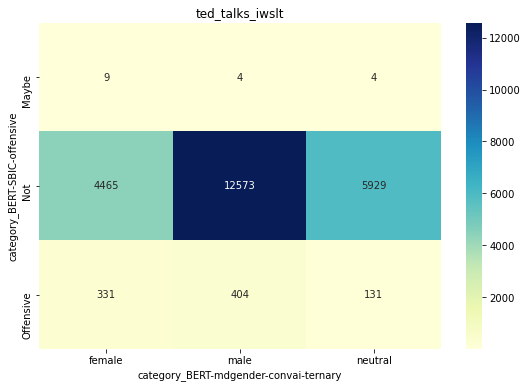

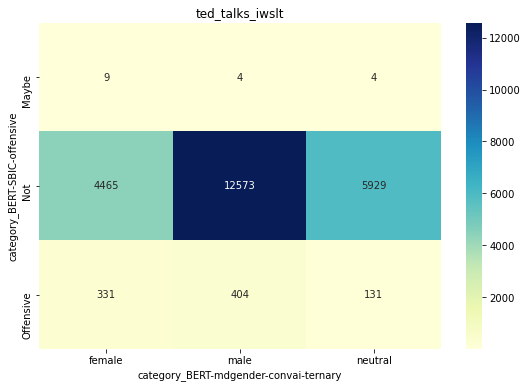

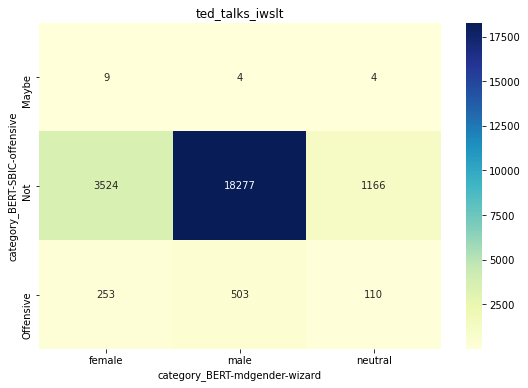

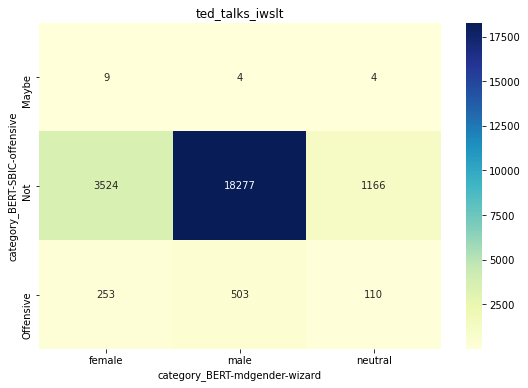

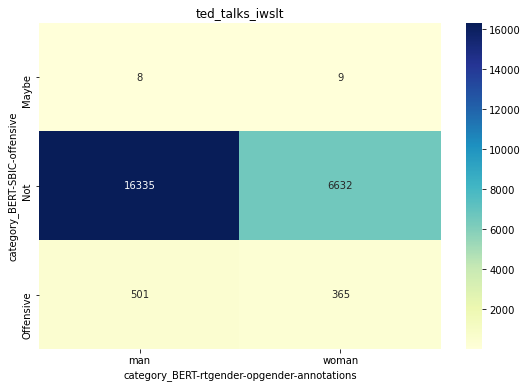

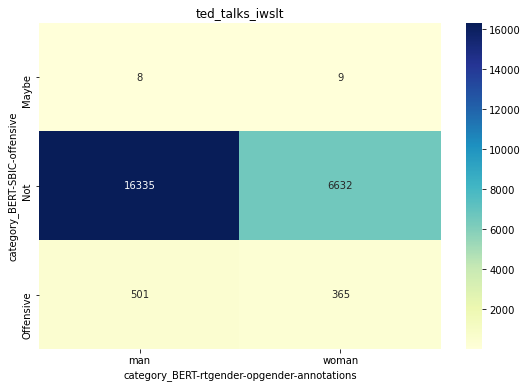

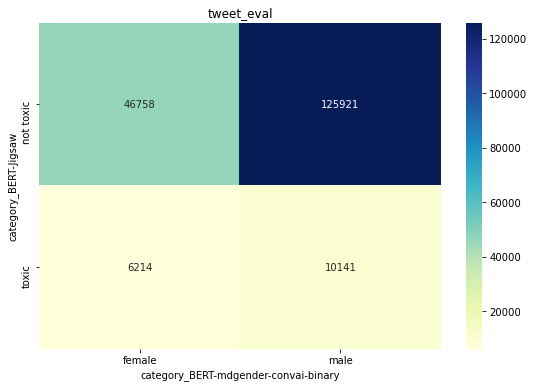

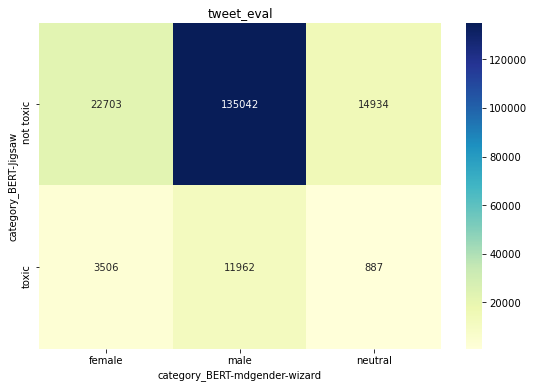

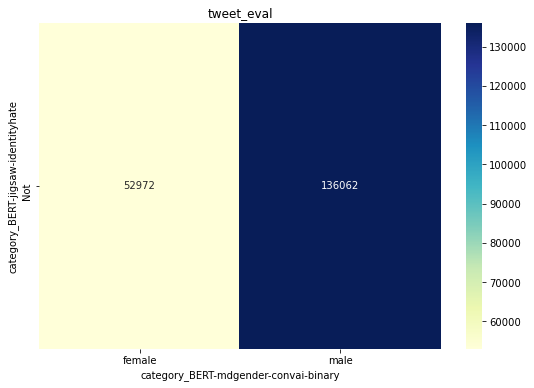

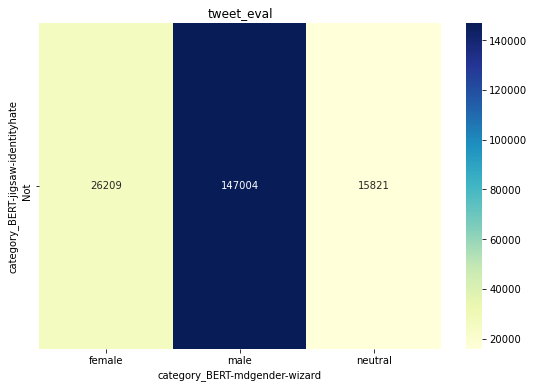

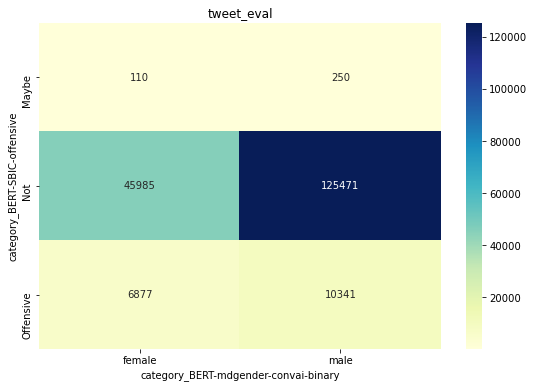

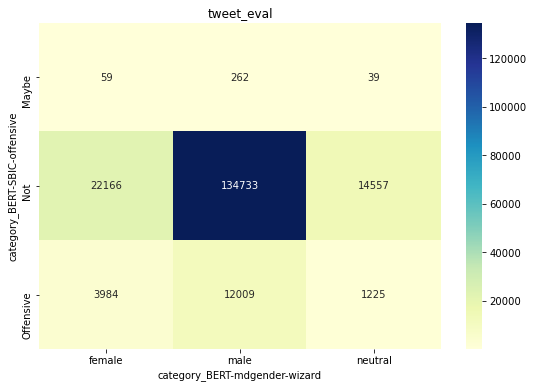

In [40]:
for eval_dataset_name, ct_list in crosstabs: 
    for ct in ct_list:
        scale_and_generate(ct, eval_dataset_name)